In [1]:
import kagglehub
import pandas as pd
import os
import pyGMs as gm
import numpy as np
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import argparse

In [2]:
# Download latest version
path = kagglehub.dataset_download("drgilermo/nba-players-stats")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\chawk\.cache\kagglehub\datasets\drgilermo\nba-players-stats\versions\2


In [3]:
df = pd.read_csv(os.path.join(path, "Seasons_Stats.csv"), encoding='latin1')

## Data Visualization and Cleaning

In [4]:
df.head(10)

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
5,5,1950.0,Ed Bartels,F,24.0,NYK,2.0,NaN,NaN,NaN,...,0.667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.0,4.0
6,6,1950.0,Ralph Beard,G,22.0,INO,60.0,NaN,NaN,NaN,...,0.762,NaN,NaN,NaN,233.0,NaN,NaN,NaN,132.0,895.0
7,7,1950.0,Gene Berce,G-F,23.0,TRI,3.0,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.0,10.0
8,8,1950.0,Charlie Black,F-C,28.0,TOT,65.0,NaN,NaN,NaN,...,0.651,NaN,NaN,NaN,163.0,NaN,NaN,NaN,273.0,661.0
9,9,1950.0,Charlie Black,F-C,28.0,FTW,36.0,NaN,NaN,NaN,...,0.632,NaN,NaN,NaN,75.0,NaN,NaN,NaN,140.0,382.0


In [5]:
df['Player'] = df['Player'].str.replace('*', '', regex=False)
df = df.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["blanl", "blank2"])
df = df[df['Year'].notna()]
df['Year'] = df['Year'].astype(int)
df = df[df['Year'] > 1973]
df = df.drop(columns=['GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', '3P', '3PA', '3P%', 'eFG%', 'ORB', 'DRB', 'PF', 'TOV'])

In [6]:
df.head(10)

,Year,Player,Pos,Age,Tm,G,WS,BPM,VORP,FG,...,2PA,2P%,FT,FTA,FT%,TRB,AST,STL,BLK,PTS
3851,1974,Zaid Abdul-Aziz,C,27.0,HOU,79.0,6.5,1.0,1.8,336.0,...,732.0,0.459,193.0,240.0,0.804,923.0,166.0,80.0,104.0,865.0
3852,1974,Kareem Abdul-Jabbar,C,26.0,MIL,81.0,18.4,8.5,9.4,948.0,...,1759.0,0.539,295.0,420.0,0.702,1178.0,386.0,112.0,283.0,2191.0
3853,1974,Don Adams,SF,26.0,DET,74.0,3.6,-1.1,0.5,303.0,...,742.0,0.408,153.0,201.0,0.761,448.0,141.0,110.0,12.0,759.0
3854,1974,Rick Adelman,PG,27.0,CHI,55.0,0.7,-3.0,-0.2,64.0,...,170.0,0.376,54.0,76.0,0.711,69.0,56.0,36.0,1.0,182.0
3855,1974,Lucius Allen,PG,26.0,MIL,72.0,8.2,3.6,3.4,526.0,...,1062.0,0.495,216.0,274.0,0.788,291.0,374.0,137.0,22.0,1268.0
3856,1974,Tiny Archibald,PG,25.0,KCO,35.0,2.3,0.6,0.8,222.0,...,492.0,0.451,173.0,211.0,0.820,85.0,266.0,56.0,7.0,617.0
3857,1974,Dennis Awtrey,C,25.0,CHI,68.0,1.4,0.3,0.4,65.0,...,123.0,0.528,54.0,94.0,0.574,174.0,86.0,22.0,14.0,184.0
3858,1974,Mike Bantom,PF,22.0,PHO,76.0,0.5,-2.9,-0.5,314.0,...,787.0,0.399,141.0,213.0,0.662,519.0,163.0,50.0,47.0,769.0
3859,1974,Dick Barnett,SG,37.0,NYK,5.0,0.0,-8.2,-0.1,10.0,...,26.0,0.385,2.0,3.0,0.667,4.0,6.0,1.0,0.0,22.0
3860,1974,Jim Barnett,SG,29.0,GSW,77.0,4.1,-0.7,0.6,350.0,...,755.0,0.464,184.0,226.0,0.814,222.0,209.0,56.0,11.0,884.0


In [7]:
nan_count = np.sum(df.isnull(), axis=0)
print(nan_count)
print(df.shape)

Year        0
Player      0
Pos         0
Age         0
Tm          0
G           0
WS          0
BPM         0
VORP        0
FG          0
FGA         0
FG%        94
2P          0
2PA         0
2P%       123
FT          0
FTA         0
FT%       792
TRB         0
AST         0
STL         0
BLK         0
PTS         0
dtype: int64
(20797, 23)


## Label Creation and Training Data

In [8]:
mvp_winners = {
    1956: "Bob Pettit",
    1957: "Bob Cousy",
    1958: "Bill Russell",
    1959: "Bob Pettit",
    1960: "Wilt Chamberlain",
    1961: "Bill Russell",
    1962: "Bill Russell",
    1963: "Bill Russell",
    1964: "Oscar Robertson",
    1965: "Bill Russell",
    1966: "Wilt Chamberlain",
    1967: "Wilt Chamberlain",
    1968: "Wilt Chamberlain",
    1969: "Wes Unseld",
    1970: "Willis Reed",
    1971: "Kareem Abdul-Jabbar",
    1972: "Kareem Abdul-Jabbar",
    1973: "Dave Cowens",
    1974: "Kareem Abdul-Jabbar",
    1975: "Bob McAdoo",
    1976: "Kareem Abdul-Jabbar",
    1977: "Kareem Abdul-Jabbar",
    1978: "Bill Walton",
    1979: "Moses Malone",
    1980: "Kareem Abdul-Jabbar",
    1981: "Julius Erving",
    1982: "Moses Malone",
    1983: "Moses Malone",
    1984: "Larry Bird",
    1985: "Larry Bird",
    1986: "Larry Bird",
    1987: "Magic Johnson",
    1988: "Michael Jordan",
    1989: "Magic Johnson",
    1990: "Magic Johnson",
    1991: "Michael Jordan",
    1992: "Michael Jordan",
    1993: "Charles Barkley",
    1994: "Hakeem Olajuwon",
    1995: "David Robinson",
    1996: "Michael Jordan",
    1997: "Karl Malone",
    1998: "Michael Jordan",
    1999: "Karl Malone",
    2000: "Shaquille O'Neal",
    2001: "Allen Iverson",
    2002: "Tim Duncan",
    2003: "Tim Duncan",
    2004: "Kevin Garnett",
    2005: "Steve Nash",
    2006: "Steve Nash",
    2007: "Dirk Nowitzki",
    2008: "Kobe Bryant",
    2009: "LeBron James",
    2010: "LeBron James",
    2011: "Derrick Rose",
    2012: "LeBron James",
    2013: "LeBron James",
    2014: "Kevin Durant",
    2015: "Stephen Curry",
    2016: "Stephen Curry",
    2017: "Russell Westbrook",
    2018: "James Harden"
}

In [9]:
df['Won_MVP'] = df.apply(lambda row: int(row['Player'] == mvp_winners.get(row['Year'])), axis=1)
df.head()

,Year,Player,Pos,Age,Tm,G,WS,BPM,VORP,FG,...,2P%,FT,FTA,FT%,TRB,AST,STL,BLK,PTS,Won_MVP
3851,1974,Zaid Abdul-Aziz,C,27.0,HOU,79.0,6.5,1.0,1.8,336.0,...,0.459,193.0,240.0,0.804,923.0,166.0,80.0,104.0,865.0,0
3852,1974,Kareem Abdul-Jabbar,C,26.0,MIL,81.0,18.4,8.5,9.4,948.0,...,0.539,295.0,420.0,0.702,1178.0,386.0,112.0,283.0,2191.0,1
3853,1974,Don Adams,SF,26.0,DET,74.0,3.6,-1.1,0.5,303.0,...,0.408,153.0,201.0,0.761,448.0,141.0,110.0,12.0,759.0,0
3854,1974,Rick Adelman,PG,27.0,CHI,55.0,0.7,-3.0,-0.2,64.0,...,0.376,54.0,76.0,0.711,69.0,56.0,36.0,1.0,182.0,0
3855,1974,Lucius Allen,PG,26.0,MIL,72.0,8.2,3.6,3.4,526.0,...,0.495,216.0,274.0,0.788,291.0,374.0,137.0,22.0,1268.0,0


In [10]:
print(list(df.columns))

['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'WS', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'PTS', 'Won_MVP']


In [11]:
df_top_scorers = df.sort_values(['Year', 'PTS'], ascending=[True, False]).groupby('Year').head(15)
df = pd.concat([
    df_top_scorers,
    df[df['Won_MVP'] == 1]
]).drop_duplicates().reset_index(drop=True)

=== Training Pyro Model ===
Training data shape: (528, 19)
Class distribution: [493  35]
MVP rate: 0.0663
Feature bins: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0] Loss: 11387.26
  Class probs: [0.50049996 0.4995    ]
[100] Loss: 11290.84
  Class probs: [0.54930764 0.4506924 ]
[200] Loss: 11226.15
  Class probs: [0.59441847 0.4055815 ]
[300] Loss: 11175.73
  Class probs: [0.6352876  0.36471245]
[400] Loss: 11135.80
  Class probs: [0.6718019 0.3281981]
[500] Loss: 11103.97
  Class probs: [0.704101 0.295899]
[600] Loss: 11078.51
  Class probs: [0.73247963 0.26752034]
[700] Loss: 11058.08
  Class probs: [0.75731146 0.24268857]
[800] Loss: 11041.64
  Class probs: [0.7789936 0.2210064]
[900] Loss: 11028.37
  Class probs: [0.79791415 0.20208582]
[1000] Loss: 11017.60
  Class probs: [0.8144321 0.1855679]
[1100] Loss: 11008.83
  Class probs: [0.8288696  0.17113034]
[1200] Loss: 11001.67
  Class probs: [0.8415095  0.15849048]
[1300] Loss: 10995.81
  Class probs: [0.8525968  0.

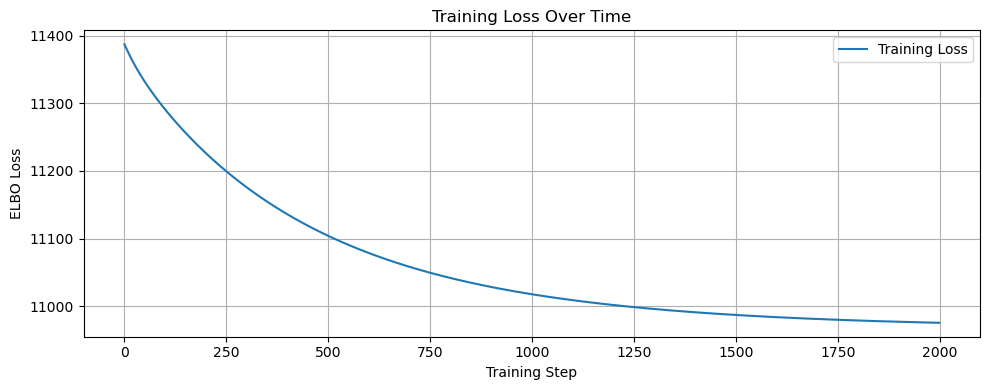


=== Evaluating Pyro Model ===
Row 0: logp=[-21.384184 -19.562054], proba=[0.13917847 0.86082155], MVP_prob=0.860822
Row 1: logp=[-21.280958 -21.248497], proba=[0.49188542 0.50811464], MVP_prob=0.508115
Row 2: logp=[-21.498074 -20.702023], proba=[0.31087092 0.6891292 ], MVP_prob=0.689129
Pyro MVP probabilities range: 0.000000 to 0.998644
Pyro MVP probabilities mean: 0.129343
Pyro MVP probabilities std: 0.298587

Pyro Correct MVP Predictions on Test Set: 3/9 (33.33%)

Test Set Accuracy: 3/9 = 33.33%

Top 5 MVP Predictions for Recent Years:

2011 (Top-5 Hit: ✔):
  LeBron James: 0.992794 
  Dwyane Wade: 0.569922 
  Dwight Howard: 0.050349 
  Derrick Rose: 0.010171 **MVP**
  Amar'e Stoudemire: 0.002521 

1998 (Top-5 Hit: ✔):
  Karl Malone: 0.998644 
  Michael Jordan: 0.630469 **MVP**
  David Robinson: 0.539139 
  Tim Duncan: 0.102660 
  Shaquille O'Neal: 0.001184 

1999 (Top-5 Hit: ✔):
  Shaquille O'Neal: 0.002104 
  Hakeem Olajuwon: 0.000086 
  Karl Malone: 0.000080 **MVP**
  Alonzo Mourn

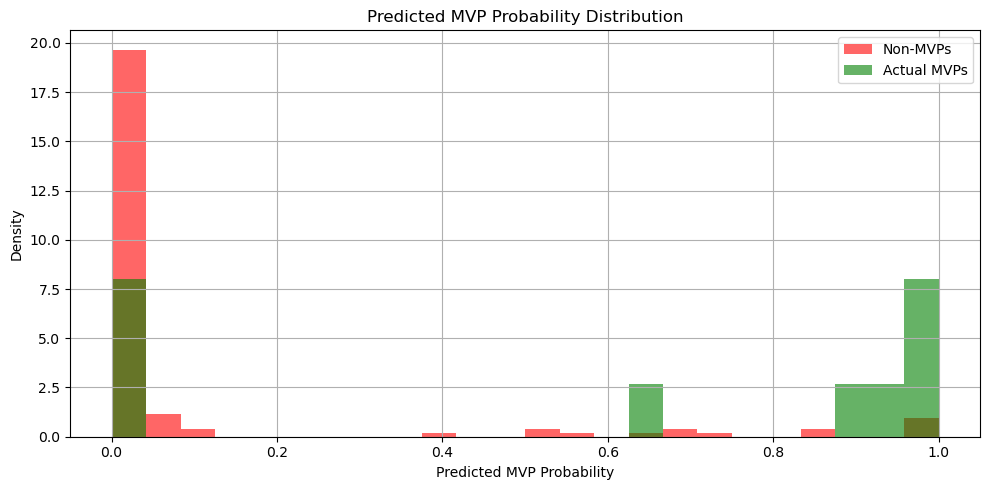

,Year,Player,Pos,Age,Tm,G,WS,BPM,VORP,FG,...,FT%,TRB,AST,STL,BLK,PTS,Won_MVP,MVP_Prob,Actual_MVP,Predicted_MVP
60,1978,George Gervin,SG,25.0,SAS,82.0,12.0,4.1,4.4,864.0,...,0.830,420.0,302.0,136.0,110.0,2232.0,0,8.608215e-01,0,1
61,1978,David Thompson,SG,23.0,DEN,80.0,12.7,3.6,4.3,826.0,...,0.778,390.0,362.0,92.0,99.0,2172.0,0,5.081146e-01,0,0
62,1978,Bob McAdoo,C,26.0,NYK,79.0,10.9,3.4,4.3,814.0,...,0.727,1010.0,298.0,105.0,126.0,2097.0,0,6.891292e-01,0,0
63,1978,Randy Smith,SG,29.0,BUF,82.0,7.9,1.7,3.1,789.0,...,0.800,310.0,458.0,172.0,11.0,2021.0,0,1.122664e-03,0,0
64,1978,Paul Westphal,SG,27.0,PHO,80.0,9.8,2.5,2.8,809.0,...,0.813,164.0,437.0,138.0,31.0,2014.0,0,9.385791e-02,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,2014,DeMarcus Cousins,C,23.0,SAC,71.0,7.9,4.7,3.9,591.0,...,0.726,831.0,207.0,109.0,91.0,1614.0,0,9.494866e-05,0,0
612,2014,LaMarcus Aldridge,PF,28.0,POR,69.0,7.5,0.3,1.5,652.0,...,0.822,765.0,178.0,63.0,68.0,1603.0,0,3.536109e-07,0,0
613,2014,Al Jefferson,C,29.0,CHA,73.0,7.8,1.8,2.5,700.0,...,0.690,792.0,155.0,67.0,79.0,1594.0,0,9.640443e-06,0,0
614,2014,John Wall,PG,23.0,WAS,82.0,7.9,2.6,3.4,579.0,...,0.805,333.0,721.0,149.0,40.0,1583.0,0,3.414109e-07,0,0


In [17]:
from pandas.api.types import is_numeric_dtype, is_object_dtype
from scipy.special import logsumexp

def load_and_preprocess_from_df(df):
    df = df.copy()
    df = df.dropna(subset=['Won_MVP'])

    y = df['Won_MVP'].astype(int).values

    exclude_cols = ['Player', 'Tm', 'Won_MVP', 'G']
    features = [col for col in df.columns if col not in exclude_cols]

    for col in features:
        if df[col].isnull().any():
            median = df[col].median()
            df[col] = df[col].fillna(median)

    bins_dict = {}
    X = []
    for col in features:
        if is_object_dtype(df[col].dtype):
            continue
        binned, bins = pd.qcut(df[col], q=3, labels=False, retbins=True, duplicates='drop')
        X.append(binned.astype(int).values)
        bins_dict[col] = bins

    X = np.stack(X, axis=1)
    return X, y, features, bins_dict


def build_model(feature_bins, num_classes=2, alpha=1.0):
    def model(X, y=None):
        class_probs = pyro.param("class_probs", 
                                 torch.ones(num_classes) / num_classes,
                                 constraint=dist.constraints.simplex)

        with pyro.plate("data", X.shape[0]):
            y_hat = pyro.sample("y", dist.Categorical(class_probs), obs=y)
            for i, bins in enumerate(feature_bins):
                init_probs = torch.ones(num_classes, bins) / bins + alpha / bins
                probs = pyro.param(f"feature_{i}_probs", 
                                  init_probs,
                                  constraint=dist.constraints.simplex)
                pyro.sample(f"feature_{i}", dist.Categorical(probs[y_hat]), obs=X[:, i])
    return model

def guide(X, y=None):
    pass 

import matplotlib.pyplot as plt

def train(X, y, feature_bins, alpha=1.0):
    pyro.clear_param_store()
    
    print(f"Training data shape: {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")
    print(f"MVP rate: {y.mean():.4f}")
    print(f"Feature bins: {feature_bins}")

    model = build_model(feature_bins, alpha=alpha)
    svi = SVI(model, guide, Adam({"lr": 0.001}), loss=Trace_ELBO())

    X_tensor = torch.tensor(X, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)

    losses = []

    for step in range(2000):
        loss = svi.step(X_tensor, y_tensor)
        losses.append(loss)
        if step % 100 == 0:
            print(f"[{step}] Loss: {loss:.2f}")
            class_probs = pyro.param("class_probs").detach().numpy()
            print(f"  Class probs: {class_probs}")

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses, label="Training Loss")
    plt.title("Training Loss Over Time")
    plt.xlabel("Training Step")
    plt.ylabel("ELBO Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# -------------------- Prediction with Better Numerical Stability --------------------

def predict_proba_stable(X_new, feature_bins):
    """Predict probabilities with better numerical stability."""
    class_probs = pyro.param("class_probs").detach().numpy()
    
    eps = 1e-10
    class_probs = np.clip(class_probs, eps, 1.0)
    
    preds_proba = []
    
    for row_idx, row in enumerate(X_new):
        logp = np.log(class_probs)
        
        for i, val in enumerate(row):
            if val >= len(pyro.param(f"feature_{i}_probs").detach().numpy()[0]):
                val = len(pyro.param(f"feature_{i}_probs").detach().numpy()[0]) - 1
                
            feature_probs = pyro.param(f"feature_{i}_probs").detach().numpy()
            feature_probs = np.clip(feature_probs, eps, 1.0)
            logp += np.log(feature_probs[:, val])
        
        log_proba_normalized = logp - logsumexp(logp)
        proba = np.exp(log_proba_normalized)
        
        proba = proba / proba.sum()
        
        preds_proba.append(proba[1]) 
        if row_idx < 3:
            print(f"Row {row_idx}: logp={logp}, proba={proba}, MVP_prob={proba[1]:.6f}")
    
    return np.array(preds_proba)


def train_sklearn_baseline(X, y):
    """Train sklearn Naive Bayes for comparison."""
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import accuracy_score, classification_report
    
    print("\n--- Sklearn Baseline ---")
    nb = MultinomialNB(alpha=1.0)
    nb.fit(X, y)
    
    probs = nb.predict_proba(X)[:, 1]
    
    print(f"Sklearn MVP probabilities range: {probs.min():.6f} to {probs.max():.6f}")
    print(f"Sklearn MVP probabilities mean: {probs.mean():.6f}")
    print(f"Sklearn MVP probabilities std: {probs.std():.6f}")
    
    return probs

from sklearn.model_selection import train_test_split

def run_pipeline_from_df(df, use_sklearn_comparison=False, test_frac=0.2, seed=42):
    unique_years = sorted(df['Year'].unique())
    train_years, test_years = train_test_split(unique_years, test_size=test_frac, random_state=seed)

    df_train = df[df['Year'].isin(train_years)].copy()
    df_test = df[df['Year'].isin(test_years)].copy()

    X_train, y_train, features, bins_dict = load_and_preprocess_from_df(df_train)
    feature_bins = [len(bins_dict[col]) - 1 for col in features if is_numeric_dtype(df[col])]

    print("=== Training Pyro Model ===")
    train(X_train, y_train, feature_bins, alpha=5.0)

    print("\n=== Evaluating Pyro Model ===")
    X_test = []
    for col in features:
        if is_object_dtype(df_test[col].dtype):
            continue
        bins = bins_dict[col]
        binned = pd.cut(df_test[col], bins=bins, labels=False, include_lowest=True)
        binned = binned.fillna(0).astype(int)
        X_test.append(binned.values)
    X_test = np.stack(X_test, axis=1)
    y_test = df_test['Won_MVP'].astype(int).values

    probs_pyro = predict_proba_stable(X_test, feature_bins)

    print(f"Pyro MVP probabilities range: {probs_pyro.min():.6f} to {probs_pyro.max():.6f}")
    print(f"Pyro MVP probabilities mean: {probs_pyro.mean():.6f}")
    print(f"Pyro MVP probabilities std: {probs_pyro.std():.6f}")

    if use_sklearn_comparison:
        probs_sklearn = train_sklearn_baseline(X_train, y_train)
        probs = probs_sklearn
        model_name = "Sklearn"
    else:
        probs = probs_pyro
        model_name = "Pyro"

    df_eval = df_test.copy()
    df_eval["MVP_Prob"] = probs
    df_eval["Actual_MVP"] = y_test

    top_preds = df_eval.loc[df_eval.groupby("Year")["MVP_Prob"].idxmax()]
    df_eval["Predicted_MVP"] = 0
    df_eval.loc[top_preds.index, "Predicted_MVP"] = 1

    correct_by_year = (top_preds["Actual_MVP"] == 1).sum()
    total_years = top_preds["Year"].nunique()
    print(f"\n{model_name} Correct MVP Predictions on Test Set: {correct_by_year}/{total_years} ({100 * correct_by_year / total_years:.2f}%)")

    correct = (top_preds["Actual_MVP"] == 1).sum()
    total = len(test_years)
    print(f"\nTest Set Accuracy: {correct}/{total} = {100 * correct / total:.2f}%")

    print(f"\nTop 5 MVP Predictions for Recent Years:")
    hit_top_5 = 0  # Count of years where true MVP is in top 5
    
    for year in test_years:
        year_data = df_eval[df_eval['Year'] == year].nlargest(5, 'MVP_Prob')
        mvp_in_top5 = (year_data["Actual_MVP"] == 1).any()
        if mvp_in_top5:
            hit_top_5 += 1
    
        print(f"\n{year} (Top-5 Hit: {'✔' if mvp_in_top5 else '✘'}):")
        for _, row in year_data.iterrows():
            mvp_status = "**MVP**" if row['Actual_MVP'] == 1 else ""
            print(f"  {row['Player']}: {row['MVP_Prob']:.6f} {mvp_status}")
    
    print(f"\nTop-5 Accuracy: {hit_top_5}/{total} = {100 * hit_top_5 / total:.2f}%")

    mvp_probs = df_eval["MVP_Prob"]
    actual_mvp = df_eval["Actual_MVP"]

    mvp_pred_probs = mvp_probs[actual_mvp == 1]
    non_mvp_pred_probs = mvp_probs[actual_mvp == 0]

    plt.figure(figsize=(10, 5))
    bins = np.linspace(0, 1, 25)

    plt.hist(non_mvp_pred_probs, bins=bins, alpha=0.6, label="Non-MVPs", color="red", density=True)
    plt.hist(mvp_pred_probs, bins=bins, alpha=0.6, label="Actual MVPs", color="green", density=True)

    plt.title("Predicted MVP Probability Distribution")
    plt.xlabel("Predicted MVP Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return df_eval
df_results = run_pipeline_from_df(df)
df_results

Train years: [1974, 1975, 1976, 1977, 1979, 1980, 1981, 1983, 1984, 1985, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2012, 2013, 2015, 2016, 2017]
Test years: [1978, 1982, 1986, 1998, 1999, 2008, 2010, 2011, 2014]
=== Training Model ===
[0] Loss: 94.98
[100] Loss: 41.29
[200] Loss: 38.17
[300] Loss: 36.69
[400] Loss: 35.78
[500] Loss: 35.18
[600] Loss: 34.76
[700] Loss: 34.45
[800] Loss: 34.22
[900] Loss: 34.04
[1000] Loss: 33.90
[1100] Loss: 33.78
[1200] Loss: 33.69
[1300] Loss: 33.61
[1400] Loss: 33.55
[1500] Loss: 33.50
[1600] Loss: 33.45
[1700] Loss: 33.42
[1800] Loss: 33.39
[1900] Loss: 33.36


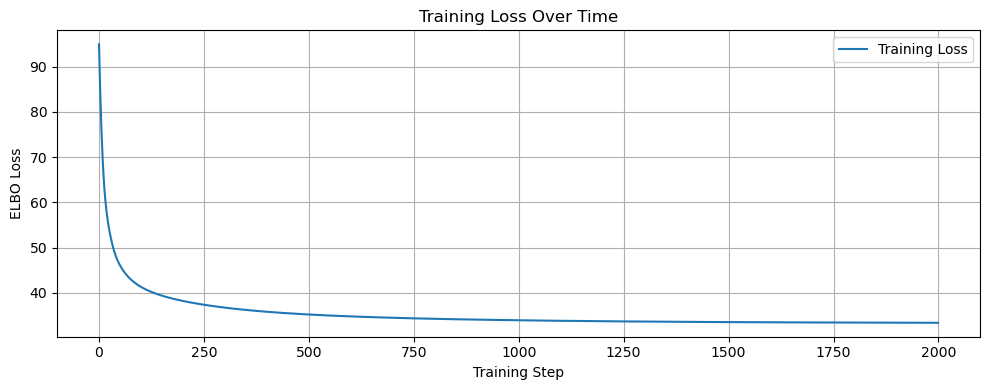


=== Predicting ===

Test Set Accuracy: 3/9 = 33.33%

Top 5 MVP Predictions for Recent Years:

2011 (Top-5 Hit: ✔):
  LeBron James: 0.933019 
  Dwight Howard: 0.022980 
  Derrick Rose: 0.012298 **MVP**
  Dwyane Wade: 0.012269 
  Kevin Martin: 0.010088 

1998 (Top-5 Hit: ✔):
  David Robinson: 0.595264 
  Karl Malone: 0.238806 
  Reggie Miller: 0.100574 
  Michael Jordan: 0.053254 **MVP**
  Tim Duncan: 0.011203 

1999 (Top-5 Hit: ✔):
  Stephon Marbury: 0.434042 
  Karl Malone: 0.184443 **MVP**
  Shaquille O'Neal: 0.113650 
  Mitch Richmond: 0.078968 
  Hakeem Olajuwon: 0.076210 

2010 (Top-5 Hit: ✔):
  LeBron James: 0.483225 **MVP**
  Amar'e Stoudemire: 0.315352 
  Dwyane Wade: 0.142057 
  Dirk Nowitzki: 0.032591 
  Kevin Durant: 0.024003 

2008 (Top-5 Hit: ✔):
  Dirk Nowitzki: 0.299819 
  Amar'e Stoudemire: 0.234427 
  LeBron James: 0.177097 
  Allen Iverson: 0.161722 
  Kobe Bryant: 0.062900 **MVP**

2014 (Top-5 Hit: ✔):
  LeBron James: 0.848133 
  Kevin Durant: 0.128720 **MVP**
  Jame

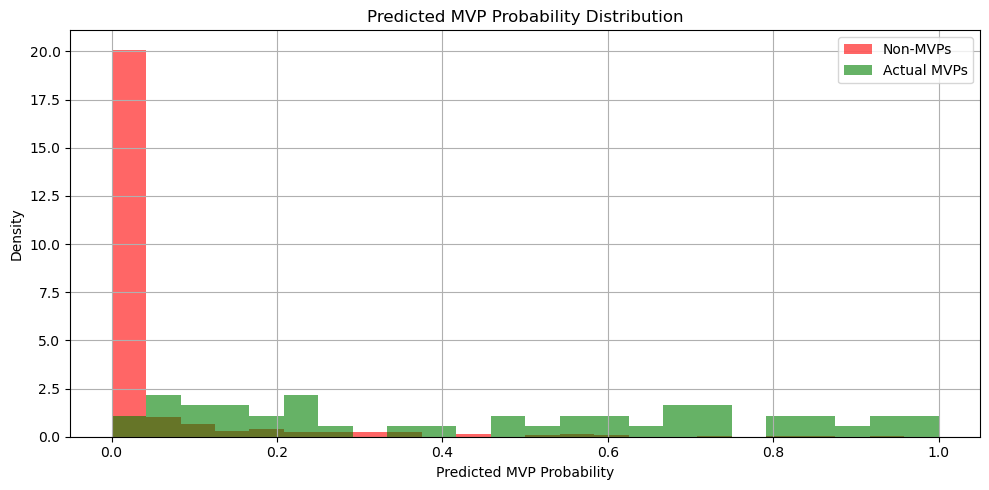

In [18]:
from pandas.api.types import is_numeric_dtype, is_object_dtype
from sklearn.model_selection import train_test_split

# -------------------- Preprocessing --------------------

def load_and_preprocess_from_df(df):
    df = df.copy()
    df = df.dropna(subset=['Won_MVP'])

    y = df['Won_MVP'].astype(int).values
    exclude_cols = ['Player', 'Tm', 'Won_MVP', 'G']
    features = [col for col in df.columns if col not in exclude_cols]

    for col in features:
        if df[col].isnull().any():
            median = df[col].median()
            df[col] = df[col].fillna(median)

    bins_dict = {}
    X = []
    for col in features:
        if is_object_dtype(df[col].dtype):
            continue
        binned, bins = pd.qcut(df[col], q=3, labels=False, retbins=True, duplicates='drop')
        X.append(binned.astype(int).values)
        bins_dict[col] = bins

    X = np.stack(X, axis=1)
    return X, y, features, bins_dict


def train_test_split_by_year(df, test_frac=0.2, seed=42):
    years = sorted(df['Year'].unique())
    train_years, test_years = train_test_split(years, test_size=test_frac, random_state=seed)
    return train_years, test_years


def reshape_data_by_year(X, y, df, selected_years):
    X_grouped, y_grouped, year_player_indices = [], [], []
    for year in selected_years:
        mask = df['Year'] == year
        X_year = X[mask]
        y_year = y[mask]
        if y_year.sum() == 0:  # Skip if no MVP for this year
            continue
        X_grouped.append(X_year)
        y_grouped.append(np.argmax(y_year))  # Index of MVP
        year_player_indices.append(np.where(mask)[0])
    return X_grouped, y_grouped, year_player_indices

# -------------------- Pyro Per-Year Model --------------------

def build_per_year_model(X_grouped, feature_bins, alpha=1.0):
    def model(y_grouped):
        num_years = len(X_grouped)

        for year_idx in pyro.plate("years", num_years):
            X_year = torch.tensor(X_grouped[year_idx], dtype=torch.long)
            feature_log_probs = []
            for i, bins in enumerate(feature_bins):
                probs = pyro.param(f"feature_{i}_probs",
                                   torch.ones(bins) / bins,
                                   constraint=dist.constraints.simplex)
                vals = X_year[:, i]
                logp = torch.log(probs[vals])
                feature_log_probs.append(logp)
            total_log_probs = torch.sum(torch.stack(feature_log_probs, dim=1), dim=1)
            pyro.sample(f"y_{year_idx}", dist.Categorical(logits=total_log_probs),
                        obs=torch.tensor(y_grouped[year_idx]))
    return model

# -------------------- Training --------------------

def train_per_year_model(X_grouped, y_grouped, feature_bins, alpha=1.0):
    pyro.clear_param_store()
    model = build_per_year_model(X_grouped, feature_bins, alpha)
    svi = SVI(model, guide=lambda *args, **kwargs: None,
              optim=Adam({"lr": 0.01}), loss=Trace_ELBO())

    losses = []
    
    for step in range(2000):
        loss = svi.step(y_grouped)
        losses.append(loss)
        if step % 100 == 0:
            print(f"[{step}] Loss: {loss:.2f}")

        # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses, label="Training Loss")
    plt.title("Training Loss Over Time")
    plt.xlabel("Training Step")
    plt.ylabel("ELBO Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------- Predict Per-Year --------------------

def predict_per_year(X_grouped, feature_bins):
    predictions = []
    for X_year in X_grouped:
        X_year = torch.tensor(X_year, dtype=torch.long)
        feature_log_probs = []
        for i, bins in enumerate(feature_bins):
            probs = pyro.param(f"feature_{i}_probs").detach()
            vals = X_year[:, i]
            logp = torch.log(probs[vals])
            feature_log_probs.append(logp)
        total_log_probs = torch.sum(torch.stack(feature_log_probs, dim=1), dim=1)
        probs = torch.softmax(total_log_probs, dim=0)
        predictions.append(probs.numpy())
    return predictions

# -------------------- Main Pipeline --------------------

def run_pipeline_from_df(df, test_frac=0.2):
    X, y, features, bins_dict = load_and_preprocess_from_df(df)
    feature_bins = [len(bins_dict[col]) - 1 for col in features if is_numeric_dtype(df[col])]

    train_years, test_years = train_test_split_by_year(df, test_frac)
    print(f"Train years: {sorted(train_years)}")
    print(f"Test years: {sorted(test_years)}")

    # Group by year
    X_train_grouped, y_train_grouped, train_indices = reshape_data_by_year(X, y, df, train_years)
    X_test_grouped, y_test_grouped, test_indices = reshape_data_by_year(X, y, df, test_years)

    # Train
    print("=== Training Model ===")
    train_per_year_model(X_train_grouped, y_train_grouped, feature_bins)

    # Predict on all years
    print("\n=== Predicting ===")
    probs_train = predict_per_year(X_train_grouped, feature_bins)
    probs_test = predict_per_year(X_test_grouped, feature_bins)

    df_eval = df.copy()
    df_eval["MVP_Prob"] = 0.0

    # Fill in predictions
    for probs, idx in zip(probs_train, train_indices):
        df_eval.loc[idx, "MVP_Prob"] = probs
    for probs, idx in zip(probs_test, test_indices):
        df_eval.loc[idx, "MVP_Prob"] = probs

    df_eval["Actual_MVP"] = y
    df_eval["Predicted_MVP"] = 0

    # Evaluate only on test set
    top_preds = df_eval[df_eval["Year"].isin(test_years)].loc[
        df_eval[df_eval["Year"].isin(test_years)].groupby("Year")["MVP_Prob"].idxmax()
    ]
    df_eval.loc[top_preds.index, "Predicted_MVP"] = 1

    correct = (top_preds["Actual_MVP"] == 1).sum()
    total = len(test_years)
    print(f"\nTest Set Accuracy: {correct}/{total} = {100 * correct / total:.2f}%")

    print(f"\nTop 5 MVP Predictions for Recent Years:")
    hit_top_5 = 0  # Count of years where true MVP is in top 5
    
    for year in test_years:
        year_data = df_eval[df_eval['Year'] == year].nlargest(5, 'MVP_Prob')
        mvp_in_top5 = (year_data["Actual_MVP"] == 1).any()
        if mvp_in_top5:
            hit_top_5 += 1
    
        print(f"\n{year} (Top-5 Hit: {'✔' if mvp_in_top5 else '✘'}):")
        for _, row in year_data.iterrows():
            mvp_status = "**MVP**" if row['Actual_MVP'] == 1 else ""
            print(f"  {row['Player']}: {row['MVP_Prob']:.6f} {mvp_status}")
    
    print(f"\nTop-5 Accuracy: {hit_top_5}/{total} = {100 * hit_top_5 / total:.2f}%")

    # -------------------- Plot Final Results --------------------

    mvp_probs = df_eval["MVP_Prob"]
    actual_mvp = df_eval["Actual_MVP"]

    mvp_pred_probs = mvp_probs[actual_mvp == 1]
    non_mvp_pred_probs = mvp_probs[actual_mvp == 0]

    plt.figure(figsize=(10, 5))
    bins = np.linspace(0, 1, 25)

    plt.hist(non_mvp_pred_probs, bins=bins, alpha=0.6, label="Non-MVPs", color="red", density=True)
    plt.hist(mvp_pred_probs, bins=bins, alpha=0.6, label="Actual MVPs", color="green", density=True)

    plt.title("Predicted MVP Probability Distribution")
    plt.xlabel("Predicted MVP Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_eval

# -------------------- Run --------------------
df_results = run_pipeline_from_df(df)